# Библиотеки

In [63]:
from abc import ABC, abstractmethod
from typing import Dict, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from implicit.als import AlternatingLeastSquares
from implicit.evaluation import precision_at_k, mean_average_precision_at_k
from scipy.sparse import csr_matrix
from sklearn.preprocessing import LabelEncoder
from tqdm.auto import tqdm

# Данные

In [64]:
data_folder = "./"

users_df = pd.read_csv(data_folder + "users_df.csv")
items_df = pd.read_csv(data_folder + "items_df.csv")

countries = pd.read_csv(data_folder + "countries.csv")
genres = pd.read_csv(data_folder + "genres.csv")
staff = pd.read_csv(data_folder + "staff.csv")

train_part = pd.read_csv(data_folder + "train_data.csv", parse_dates=["datetime"])
test_part = pd.read_csv(data_folder + "test_data.csv")
test_part = test_part.groupby("user_id").agg({"movie_id": list}).reset_index()


# Метрики

In [65]:
# ACHTUNG! DO NOT TOUCH 

def ndcg_metric(gt_items: np.ndarray, predicted: np.ndarray) -> float:
    at = len(predicted)
    relevance = np.array([1 if x in predicted else 0 for x in gt_items])
    # DCG uses the relevance of the recommended items
    rank_dcg = dcg(relevance)
    if rank_dcg == 0.0:
        return 0.0

    # IDCG has all relevances to 1 (or the values provided), up to the number of items in the test set that can fit in the list length
    ideal_dcg = dcg(np.sort(relevance)[::-1][:at])

    if ideal_dcg == 0.0:
        return 0.0

    ndcg_ = rank_dcg / ideal_dcg

    return ndcg_


def dcg(scores: np.ndarray) -> float:
    return np.sum(
        np.divide(np.power(2, scores) - 1, np.log2(np.arange(scores.shape[0], dtype=np.float64) + 2)), dtype=np.float64
    )


def recall_metric(gt_items: np.ndarray, predicted: np.ndarray) -> float:
    n_gt = len(gt_items)
    intersection = len(set(gt_items).intersection(set(predicted)))
    return intersection / n_gt


def evaluate_recommender(df: pd.DataFrame, model_preds_col: str, gt_col: str = "movie_id") -> Dict[str, float]:
    metric_values = []

    for _, row in df.iterrows():
        metric_values.append(
            (ndcg_metric(row[gt_col], row[model_preds_col]), recall_metric(row[gt_col], row[model_preds_col]))
        )

    return {"ndcg": np.mean([x[0] for x in metric_values]), "recall": np.mean([x[1] for x in metric_values])}

#### Класс, от которого стоит наследовать все ваши модели, чтобы эксперименты было проще проводить

In [66]:
class BaseRecommender(ABC):
    def __init__(self):
        self.trained = False

    @abstractmethod
    def fit(self, df: pd.DataFrame) -> None:
        # реализация может быть любой, никаких ограничений
    
        # не забудьте про
        self.trained = True

    @abstractmethod
    def predict(self, df: pd.DataFrame, topn: int = 10) -> List[np.ndarray]:
        # реализация может быть любой, НО
        # должен возвращать список массивов из movie_id, которые есть в `item_df`, чтобы корректно работал подсчет метрик
        pass

Раз уж у нас данные из неявных взаимодействий, то появилась мысль затюнить ALS из примера, чтобы работать с confidence matrix и параметром, отвечающим за вес (не)нужных нам взаимодействий.

$C_{ij} = 1 + \alpha \times R_{ij},$ \
где $\alpha - $ гиперпараметр, который отвечает за важность каждого взаимодействия \
$ R_{ij} - $ изначальная матрица взаимодействия
 
 Далее были учтены веса для набо жанров через бинарное представление (с весом $\frac{\alpha}{10}$) и для годов производства по приницу: новинки смотрятся в первую очередь (с весом $\frac{\alpha}{100}$), а общий вес считается как произведение этих двух.

In [67]:
class ImplicitALS(BaseRecommender):
    def __init__(self, factors: int = 100, regularization: float = 0.01, alpha: float = 1.0, iterations: int = 15, **kwargs) -> None:
        super().__init__()
        self.model = AlternatingLeastSquares(
            factors=factors, regularization=regularization, iterations=iterations, **kwargs
        )
        self.alpha = alpha  # Параметр alpha для взвешивания confidence matrix, по умолчанию ставим 1.0
        self.trained = False

    def _calculate_item_features(self, item_df: pd.DataFrame, item_ids: np.ndarray) -> pd.DataFrame:
        """
        Извлекает год и жанры для каждого фильма из item_df и фильтрует по item_ids (фильмы, которые смотрели пользователи).
        Создается бинарное представление всех жанров.
        Возвращает датафрейм с годом и бинарными представлениями жанров.
        """
        # Извлекаем только нужные фильмы, ведь есть те, которые зрители не смотрели.
        # Если это не учесть, то необходимые для умножения размеры матриц будут различными.
        item_features = item_df[item_df['id'].isin(item_ids)].copy()

        # Преобразуем дату в год
        item_features['year'] = pd.to_datetime(item_features['year'], errors='coerce').dt.year

        # Создаем список уникальных жанров для многомерного кодирования
        unique_genres = set()
        item_features['genres_list'] = item_features['genres'].apply(lambda x: [int(g) for g in x.strip('[]').split(',') if g.strip().isdigit()])
        for genres in item_features['genres_list']:
            unique_genres.update(genres)
        
        # Сортируем для единообразия
        unique_genres = sorted(unique_genres)  

        # Создаем бинарное представление жанров
        for genre in unique_genres:
            item_features[f'genre_{genre}'] = item_features['genres_list'].apply(lambda x: 1 if genre in x else 0)

        # Возвращаем датафрейм с годом и бинарными представлениями жанров
        genre_columns = [f'genre_{genre}' for genre in unique_genres]
        return item_features[['id', 'year'] + genre_columns]

    def _apply_item_weights(self, interaction_matrix: csr_matrix, item_features: pd.DataFrame, item_ids: np.ndarray) -> csr_matrix:
        """
        Корректирует веса в interaction_matrix на основе года и жанров фильмов.
        Для фильмов с несколькими жанрами вес рассчитывается как средний по жанрам.
        Возвращает матрицу с учетом весов жанра + года выпуска.
        """
        # Нормализуем год для применения весов
        current_year = pd.Timestamp.now().year
        
        # Применяем веса для фильмов
        for idx, item_id in enumerate(item_ids):
            if idx >= interaction_matrix.shape[1]:
                # Если индекс фильма выходит за пределы количества столбцов в interaction_matrix, пропускаем
                continue

            # Получаем данные о фильме (год и жанры)
            movie_features = item_features[item_features['id'] == item_id]
            if movie_features.empty:
                continue

            year = movie_features['year'].values[0]

            # Рассчитываем вес для года (чем новее фильм, тем больше вес) с учетом alpha
            year_weight = 1 + (current_year - year) * self.alpha / 100

            # Рассчитываем средний вес по жанрам
            genre_columns = [col for col in movie_features.columns if col.startswith('genre_')]
            genre_weights = movie_features[genre_columns].values[0]

            # Усредненный вес по жанрам, тоже с учетом alpha как доверительного коэффициента
            average_genre_weight = 1 + (np.mean(genre_weights) * self.alpha / 10)  

            # Общий вес
            total_weight = year_weight * average_genre_weight

            # Применяем общий вес к строке матрицы, соответствующей данному item_id
            interaction_matrix[:, idx] = interaction_matrix[:, idx].multiply(total_weight)

        return interaction_matrix


    def fit(self, df: pd.DataFrame, item_df: pd.DataFrame, item_col: str = "movie_id", user_col: str = "user_id", value_col: str = None) -> None:
        """
        Подготовка данных и обучение модели на неявных данных.
        df - взаимодействия пользователей с фильмами.
        item_df - информация о фильмах (жанры и год производства).
        value_col: значение взаимодействия, если None, то использовать бинарное взаимодействие.
        """

        self.user_encoder = LabelEncoder()
        self.item_encoder = LabelEncoder()

        # Преобразуем пользователей и фильмы в числовые id
        user_ids = self.user_encoder.fit_transform(df[user_col])
        item_ids = self.item_encoder.fit_transform(df[item_col])

        if value_col is None:
            counts = np.ones(len(df))
        else:
            counts = df[value_col].values
        
        # Создаем interaction matrix (пользователь, фильм) с количеством взаимодействий
        matrix_shape = (len(self.user_encoder.classes_), len(self.item_encoder.classes_))
        interaction_matrix = csr_matrix((counts, (user_ids, item_ids)), shape=matrix_shape)

        # Добавляем alpha в веса матрицы взаимодействий
        interaction_matrix = interaction_matrix.multiply(self.alpha)

        # считаем, что взаимодействия, где нулевые значения(нет активности), уже учтены как значения, к которым вес не добавляем
        # (к разреженной матрице единицу пробемно добавить, потому что разреженность нарушается)
        interaction_matrix.data += 1 # Добавляем 1 только к ненулевым элементам

          #######
#         # по поводу комментария про добавление единицы
#         # пробовал 
#         # identity_matrix = csr_matrix(np.ones(interaction_matrix.shape))- создаем единичную разреженную матрицу размеров interaction_matrix
#         # self.confidence_matrix = (identity_matrix + interaction_matrix.multiply(self.alpha)).astype("double")
#         # но при запуске ячейки с подсчетом метрик мгновенно падало ядро, поэтому предполагаем по итогу без единицы на нулевых случаях 
          #######




        # Извлекаем фичи для фильмов, которые взаимодействовали с пользователями
        item_features = self._calculate_item_features(item_df, item_ids)

        # Применяем веса на основе года и жанра
        weight_interaction_matrix = self._apply_item_weights(interaction_matrix, item_features, item_ids)
        
        # Обучаем модель на скорректированной confidence_matrix
        self.confidence_matrix = weight_interaction_matrix
        self.model.fit(self.confidence_matrix)
        self.trained = True

    def predict(self, df: pd.DataFrame, topn: int = 10) -> List[np.ndarray]:
        """
        Предсказание фильмов для пользователя по функции recommend модели.
        Возвращает список topn фильмов.
        """
        assert self.trained

        all_recs = []

        # Преобразуем пользователей
        users = self.user_encoder.transform(df["user_id"])

        # Генерируем рекомендации для каждого пользователя
        for user in tqdm(users, desc="predicting", leave=False):
            # Для данного пользователя делаем прогноз на topn фильмов
            recommended_items, _ = self.model.recommend(user, self.confidence_matrix[user], N=topn)
            # Декодируем id фильмов обратно
            all_recs.append(self.item_encoder.inverse_transform(recommended_items))

        return all_recs


    

Считаем метрики


$\alpha = 1.0 $ тестируем с гиперпараметрами из примера



In [68]:
import time 

start = time.time() # Добавим таймер, чтобы увидеть длительность процесса для сравнения с примером

als_rec = ImplicitALS(iterations=1, factors=2, alpha=1.0, random_state=42)
als_rec.fit(df = train_part, item_df= items_df)
test_part["implicit_als_recs"] = als_rec.predict(test_part)

end = time.time() - start 

print(int(end), "s -- fit + predict") ## Выводим время 


  0%|          | 0/1 [00:00<?, ?it/s]

predicting:   0%|          | 0/66900 [00:00<?, ?it/s]

81 s -- fit + predict


Замечаем, что длительность fit + predict значительно возросла. Предположительно это связано с появлением дополнительных матриц и расчета их перемножения на матрицу взаимодействий.

In [69]:
evaluate_recommender(test_part, model_preds_col="implicit_als_recs")


{'ndcg': np.float64(0.07964188700384324),
 'recall': np.float64(0.03543281484609385)}

Качество все еще не стало лучше, чем у популярных фильмов, но модель показала результат чуточку выше, чем исходная в примере. Так что возникает мысль выбора оптимального гиперпараметра $\alpha$ с надеждой превзойти. Попробуем написать кросс-валидацию и надеяться на чудо, что повезет.

In [70]:
## to be continued ....

## Сделаем небольшой EDA наших предсказаний от нового ALS.

### Посмотрим, что наш алгоритм чаще всего рекомендует первым делом:

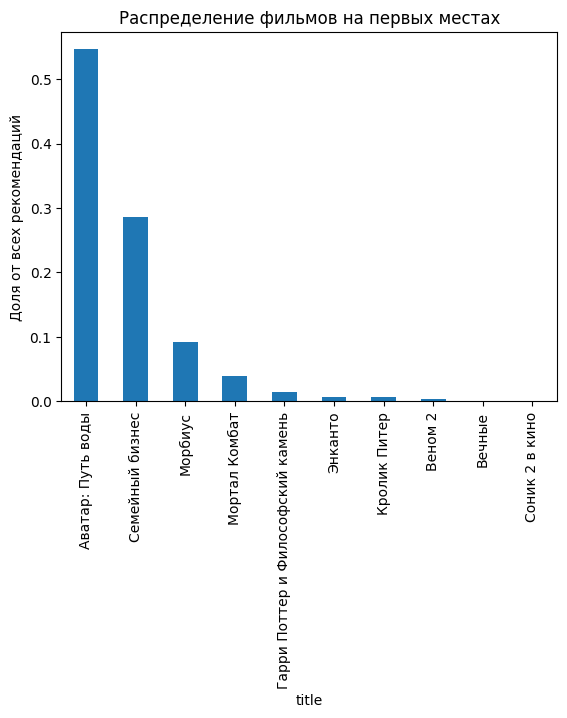

In [71]:
first_items = pd.DataFrame([x[0] for x in test_part["implicit_als_recs"].values], columns=["id"])
first_items = (
    first_items.merge(items_df[["id", "title"]], on="id").groupby("title").size().sort_values(ascending=False)
)
first_items /= first_items.sum()
first_items.head(10).plot(kind="bar")
plt.ylabel("Доля от всех рекомендаций")
plt.title("Распределение фильмов на первых местах")
plt.show()


#### "Аватар: Путь воды" все еще на первом месте, но можем заметить перестановки на остальных местах.
#### Посмотрим на похожие фильмы к фильу "Аватар: Путь воды", согласно новому als

In [72]:
items_df[items_df["title"] == 'Аватар: Путь воды']


,id,title,year,date_publication,description,genres,countries,staff,title_orig,age_rating,keywords
484,484,Аватар: Путь воды,2023-01-01,2023-04-19T00:00:00,Джейк Салли живёт в образе аватара уже много л...,"[158, 294, 266, 302]",[102],"[15325, 23343, 18928, 23330, 5187, 30892, 1481...",NaN,NaN,NaN


In [73]:
def get_similar_films(title, N=10):
    item_id = items_df[items_df["title"] == title]['id'].values[0]

    similar_encoded_ids = als_rec.model.similar_items(
        als_rec.item_encoder.transform([item_id]), N=N, filter_items=als_rec.item_encoder.transform([item_id])
    )[0][0]
    similar_ids = als_rec.item_encoder.inverse_transform(similar_encoded_ids)
    return items_df[items_df["id"].isin(similar_ids)]["title"]

In [74]:
get_similar_films("Аватар: Путь воды")

1023                                  Алые паруса
1350                 Гарри Поттер и Орден Феникса
1789                           Небеса обетованные
2002                                   Суета сует
2577                                Король Ричард
4112                                      Бладшот
5853                          Святым тут не место
6492    Мартин Лютер Кинг: Король без королевства
6957                              Назад в будущее
7043                               Обратная связь
Name: title, dtype: object

#### Получается, что после добавления распределения по жанрам и годам 31 июня уже нет, но появились новые фильмы, так что есть основания полагать, что схожесть по значениям у метрик не просто ошибка округления, а действительно новый результат.